# Parallelization strategies

pyABC supports various parallelization engines, for multi-core and distributed systems. This is described in detail in the [documentation](https://pyabc.readthedocs.io/en/latest/sampler.html), see there for details. In this notebook, we perform a little comparison of the various algorithmic parallelization strategies, using the redis-based samplers.

We consider a simple toy model:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import time
import logging
import tempfile
import pyabc

%matplotlib inline
pyabc.settings.set_figure_params('pyabc')  # for beautified plots


# unset worker info logging
logging.getLogger("Redis-Worker").setLevel(logging.WARNING)

# initialize global random state
np.random.seed(0)

def model(p):
    time.sleep(np.random.lognormal(mean=-7, sigma=2))
    return {"data": p["$\theta_0$"] + 0.5 * np.random.randn()}

# observed data
p_true = {"$\theta_0$": 2.5}
measured_data = model(p_true)

# prior
prior = pyabc.Distribution(
    {"$\theta_0$": pyabc.RV("uniform", 0, 5)})
p_lims = {"$\theta_0$": (0, 5)}

def distance(x, y):
    return abs(x["data"] - y["data"])

pop_size = 100
list_eps = pyabc.ListEpsilon([2, 0.5, 0.125, 0.0325])

## Static Scheduling (STAT)

sampler = pyabc.RedisStaticSamplerServerStarter(workers=4)
abc = pyabc.ABCSMC(model, prior, distance, eps=list_eps,
                   population_size=pop_size, sampler=sampler)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
h_stat = abc.run(max_nr_populations=len(list_eps))

## Dynamic Scheduling (DYN)

sampler = pyabc.RedisEvalParallelSamplerServerStarter(workers=4)

abc = pyabc.ABCSMC(model, prior, distance, eps=list_eps,
                   population_size=pop_size, sampler=sampler)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
h_dyn = abc.run(max_nr_populations=len(list_eps))

## Look-Ahead Dynamic Scheduling (LA)

In [2]:
sampler_file = tempfile.mkstemp(suffix=".csv")[1]

sampler = pyabc.RedisEvalParallelSamplerServerStarter(
    workers=4, look_ahead=True, look_ahead_delay_evaluation=False,
    log_file=sampler_file)

abc = pyabc.ABCSMC(model, prior, distance, eps=list_eps,
                   population_size=pop_size, sampler=sampler)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
h_la = abc.run(max_nr_populations=len(list_eps))

INFO:History:Start <ABCSMC(id=1, start_time=2021-02-03 13:14:33.619630)>
INFO:ABC:t: 0, eps: 2.
INFO:ABC:Acceptance rate: 100 / 132 = 7.5758e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.5.
INFO:ABC:Acceptance rate: 100 / 395 = 2.5316e-01, ESS=9.9898e+01.
INFO:ABC:t: 2, eps: 0.125.
INFO:ABC:Acceptance rate: 100 / 777 = 1.2870e-01, ESS=8.7766e+01.
INFO:ABC:t: 3, eps: 0.0325.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:ABC:Acceptance rate: 100 / 3274 = 3.0544e-02, ESS=4.4185e+01.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=1, duration=0:00:11.902711, end_time=2021-02-03 13:14:45.522341>


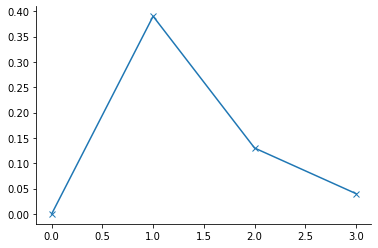

In [3]:
sampler_df = pd.read_csv(sampler_file)
_, ax = plt.subplots()
ax.plot(sampler_df['t'],
        np.minimum(pop_size, sampler_df['n_lookahead_accepted']) / pop_size,
       'x-')

In [4]:
sampler_df

,Unnamed: 0,t,n_evaluated,n_accepted,n_lookahead,n_lookahead_accepted,n_preliminary
0,0,0,132,101,0,0,0
1,1,1,395,103,158,39,0
2,2,2,777,101,88,13,0
3,3,3,3274,100,176,4,0


<AxesSubplot:title={'center':'Acceptance rates'}, xlabel='Population index', ylabel='Acceptance rate'>

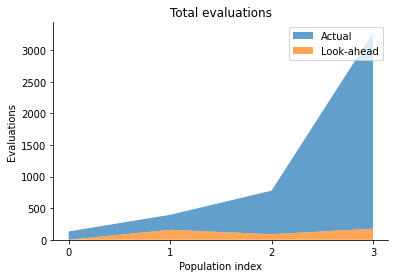

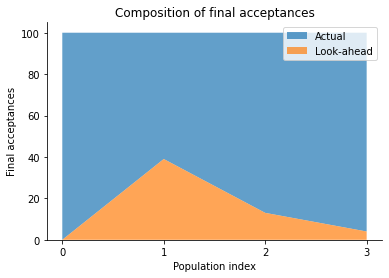

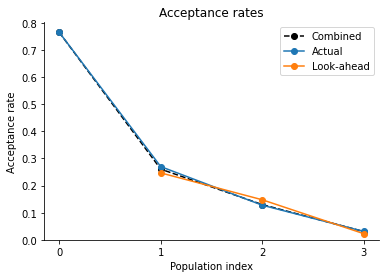

In [5]:
pyabc.visualization.plot_lookahead_evaluations(sampler_df, fill=True)
pyabc.visualization.plot_lookahead_final_acceptances(sampler_df, h_la, fill=True)
pyabc.visualization.plot_lookahead_all_acceptances(sampler_df)

## Comparison

### Posterior approximation

This should be pretty much the same across all samplers, otherwise a sampler is doing something wrong.

In [6]:
hs = [h_stat, h_dyn, h_la]
h_labels = ["STAT", "DYN", "LA"]

fig, ax = plt.subplots()
x = "$\theta_0$"
for h, label in zip(hs, h_labels):
    pyabc.visualization.plot_kde_1d_highlevel(
        h, x=x, xmin=p_lims[x][0], xmax=p_lims[x][1], label=label, ax=ax)
ax.legend()

NameError: name 'h_stat' is not defined

### Diagnostics

Number of samples:

In [ ]:
pyabc.visualization.plot_sample_numbers(hs, h_labels)

Total wall times:

In [ ]:
h_dyn.get_all_populations()

In [ ]:
pyabc.visualization.plot_total_walltime(hs)

In [ ]:
pops = h_dyn.get_all_populations()
pops